<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [ ]:
!pip install -r https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt

In [2]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [3]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 18.7MB/s]                   


Взглянем на то, что представляют из себя данные:

In [4]:
df.head()

,Date,CashIn,CashOut
4,1/5/2016,20840.0,22200.0
5,1/6/2016,28460.0,18810.0
6,1/7/2016,19250.0,23210.0
7,1/8/2016,49770.0,4350.0
8,1/9/2016,NaN,NaN


В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [5]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [6]:
from matplotlib import pyplot as plt
import datetime
import calendar

Функция для приведения дат к числовому виду

In [7]:
def tonum(date, pivot_y=2010, pivot_m=1):
  m, d, y = date.split('/')
  return (datetime.date(int(y), int(m), int(d)) - datetime.date(pivot_y, pivot_m, 1)).days

Функция для определения дня недели по дате

In [8]:
def toweekday(date):
  m, d, y = date.split('/')
  return datetime.date(int(y), int(m), int(d)).weekday()

Создаю колонки с новым обозначением дат, с годом, месяцем и днём

In [9]:
df['DDate'] = df['Date'].apply(tonum) - min(df['Date'].apply(tonum))
df['Year'] = df['Date'].apply(lambda x: int(x.split('/')[2]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('/')[0]))
df['Day'] = df['Date'].apply(lambda x: int(x.split('/')[1]))

Строю простой график

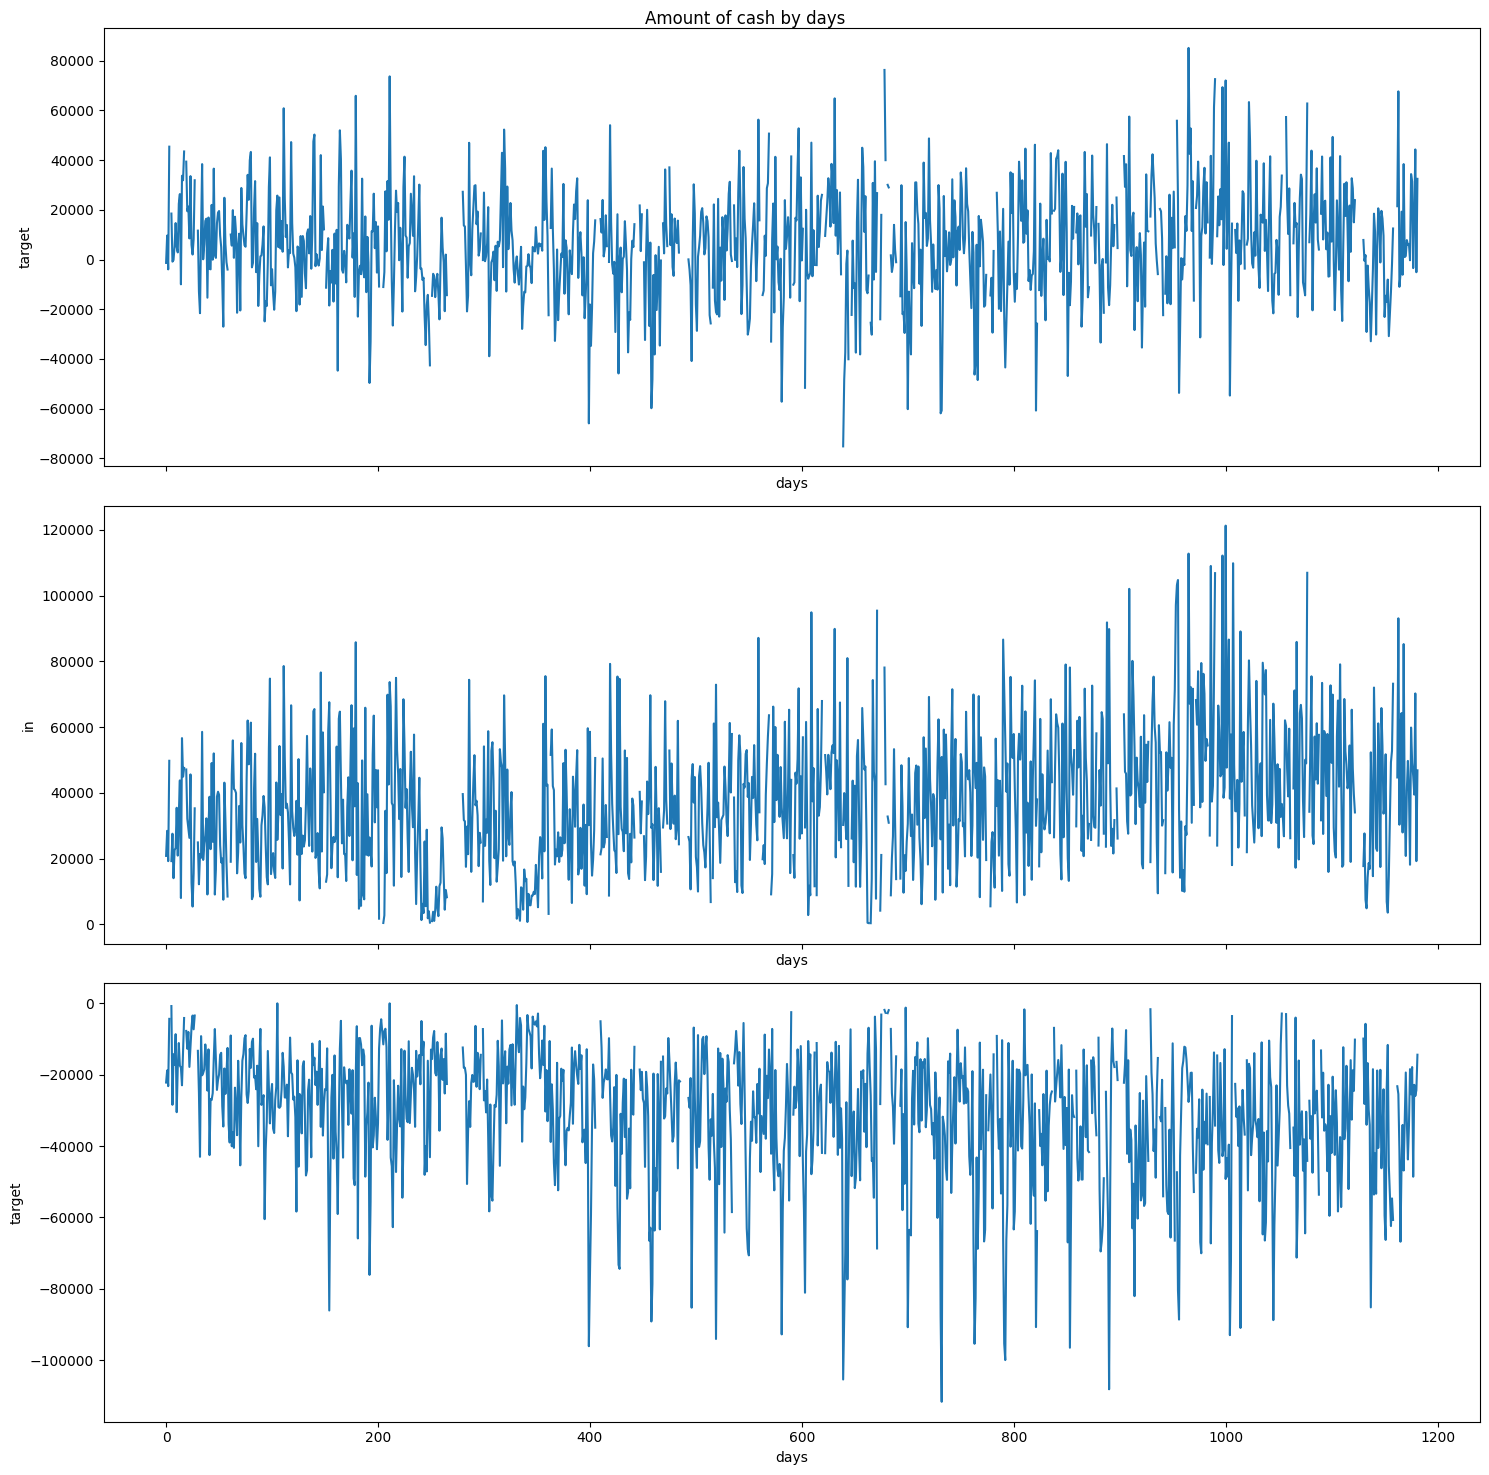

In [10]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.plot(df.DDate, df.target, label='tagret')
ax1.set_ylabel('target')
ax1.set_xlabel('days')

ax2.plot(df.DDate, df.CashIn, label='in')
ax2.set_ylabel('in')
ax2.set_xlabel('days')

ax3.plot(df.DDate, df.CashOut, label='out')
ax3.set_ylabel('target')
ax3.set_xlabel('days')

fig.suptitle('Amount of cash by days')
fig.tight_layout()
fig.show()

По этому графику сложно определить какие-либо сезонности или тренд, пробую смотреть более дробно

In [11]:
years = np.unique(df['Year'].values)
years

array([2016, 2017, 2018, 2019])

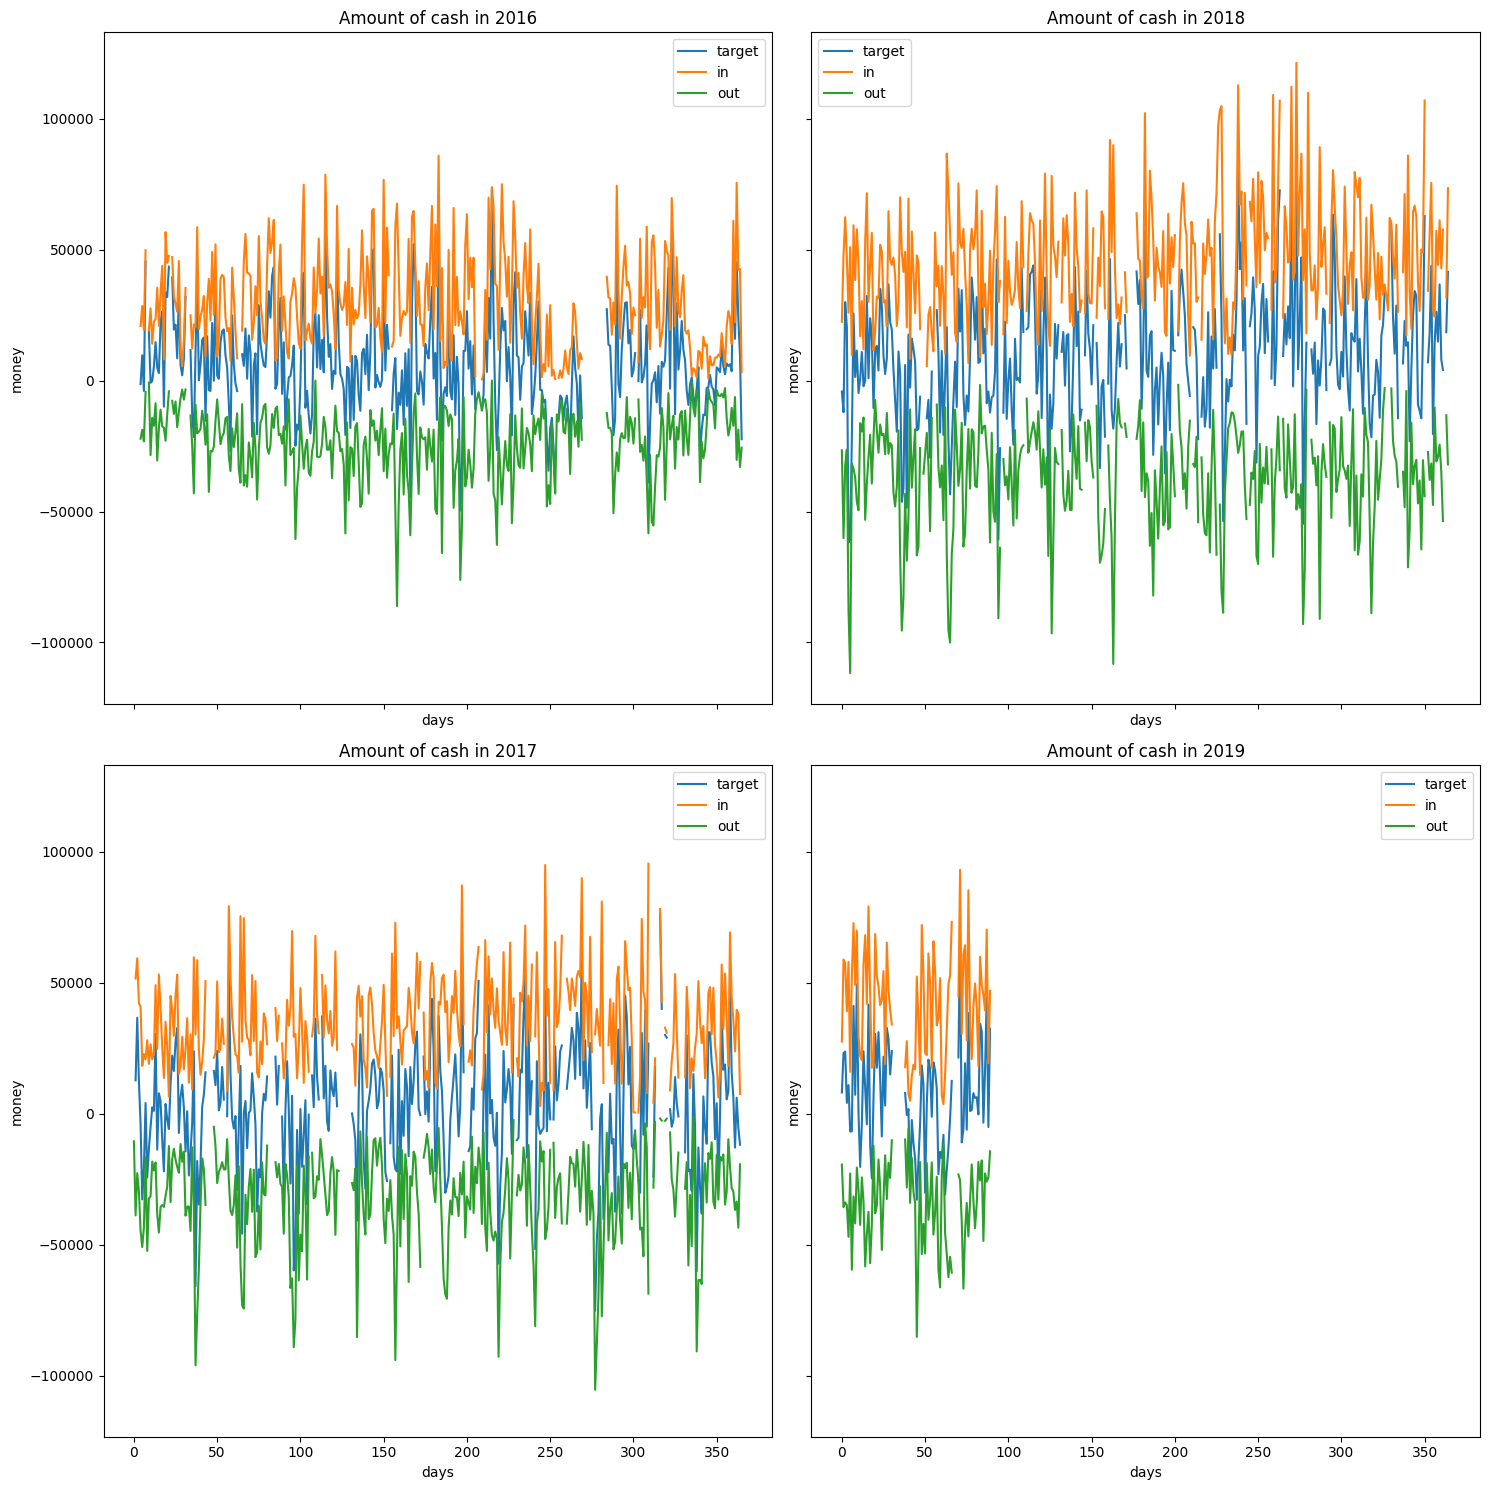

In [12]:
fig, plots = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,15))
for i in range(len(years)):
  year_data = df[df['Year'] == years[i]]
  days = (year_data['Date'].apply(lambda x: tonum(x, years[i]))).values
  plots[i%2, i//2].plot(days, year_data.target, label="target")
  plots[i%2, i//2].plot(days, year_data.CashIn, label='in')
  plots[i%2, i//2].plot(days, year_data.CashOut, label='out')
  plots[i%2, i//2].legend()
  plots[i%2, i//2].set_ylabel('money')
  plots[i%2, i//2].set_xlabel('days')
  plots[i%2, i//2].set_title(f'Amount of cash in {years[i]}')
fig.tight_layout()
fig.show()

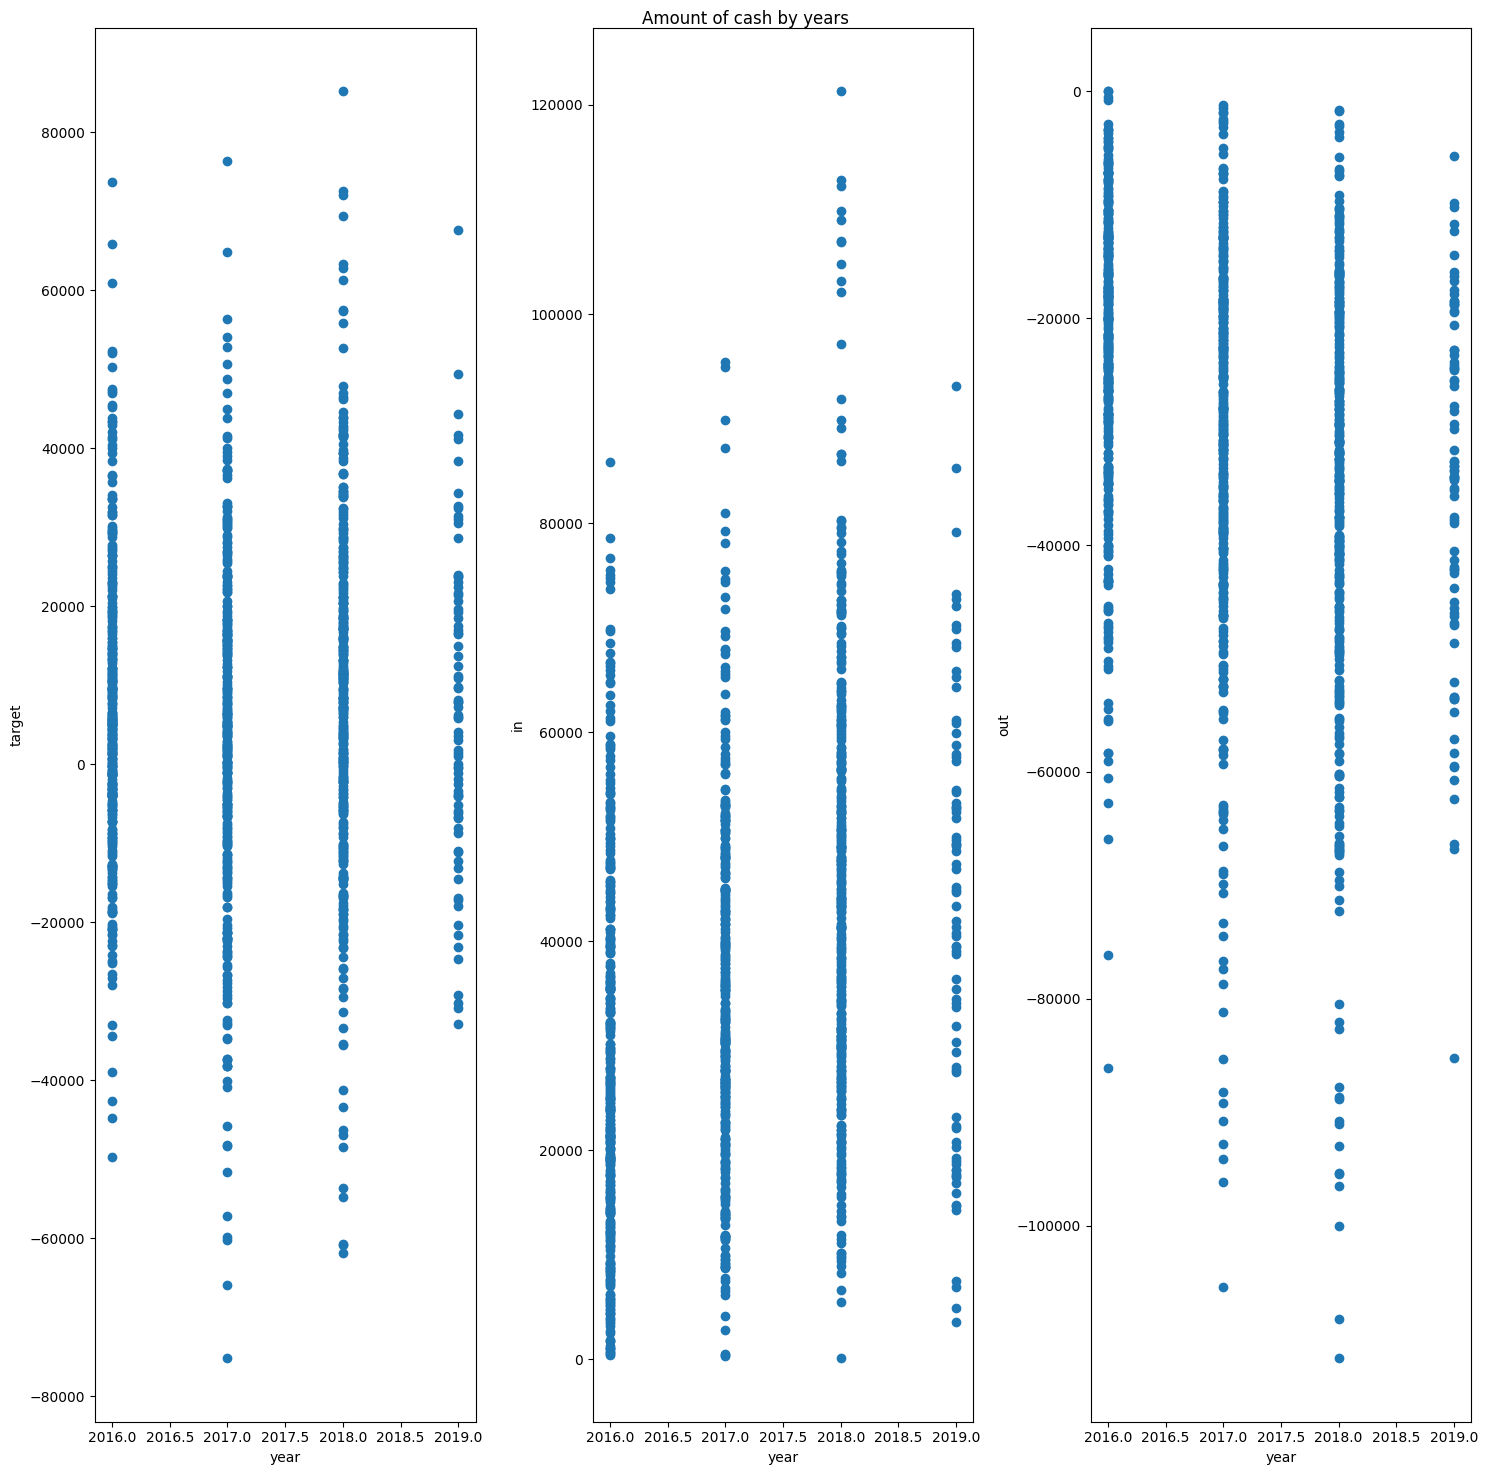

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15,15))
ax1.scatter(df['Year'], df['target'])
ax1.set_ylabel('target')
ax1.set_xlabel('year')

ax2.scatter(df['Year'], df['CashIn'])
ax2.set_ylabel('in')
ax2.set_xlabel('year')

ax3.scatter(df['Year'], df['CashOut'])
ax3.set_ylabel('out')
ax3.set_xlabel('year')

fig.suptitle('Amount of cash by years')
fig.tight_layout()
fig.show()

Здесь также довольно трудно что-то определить визуально

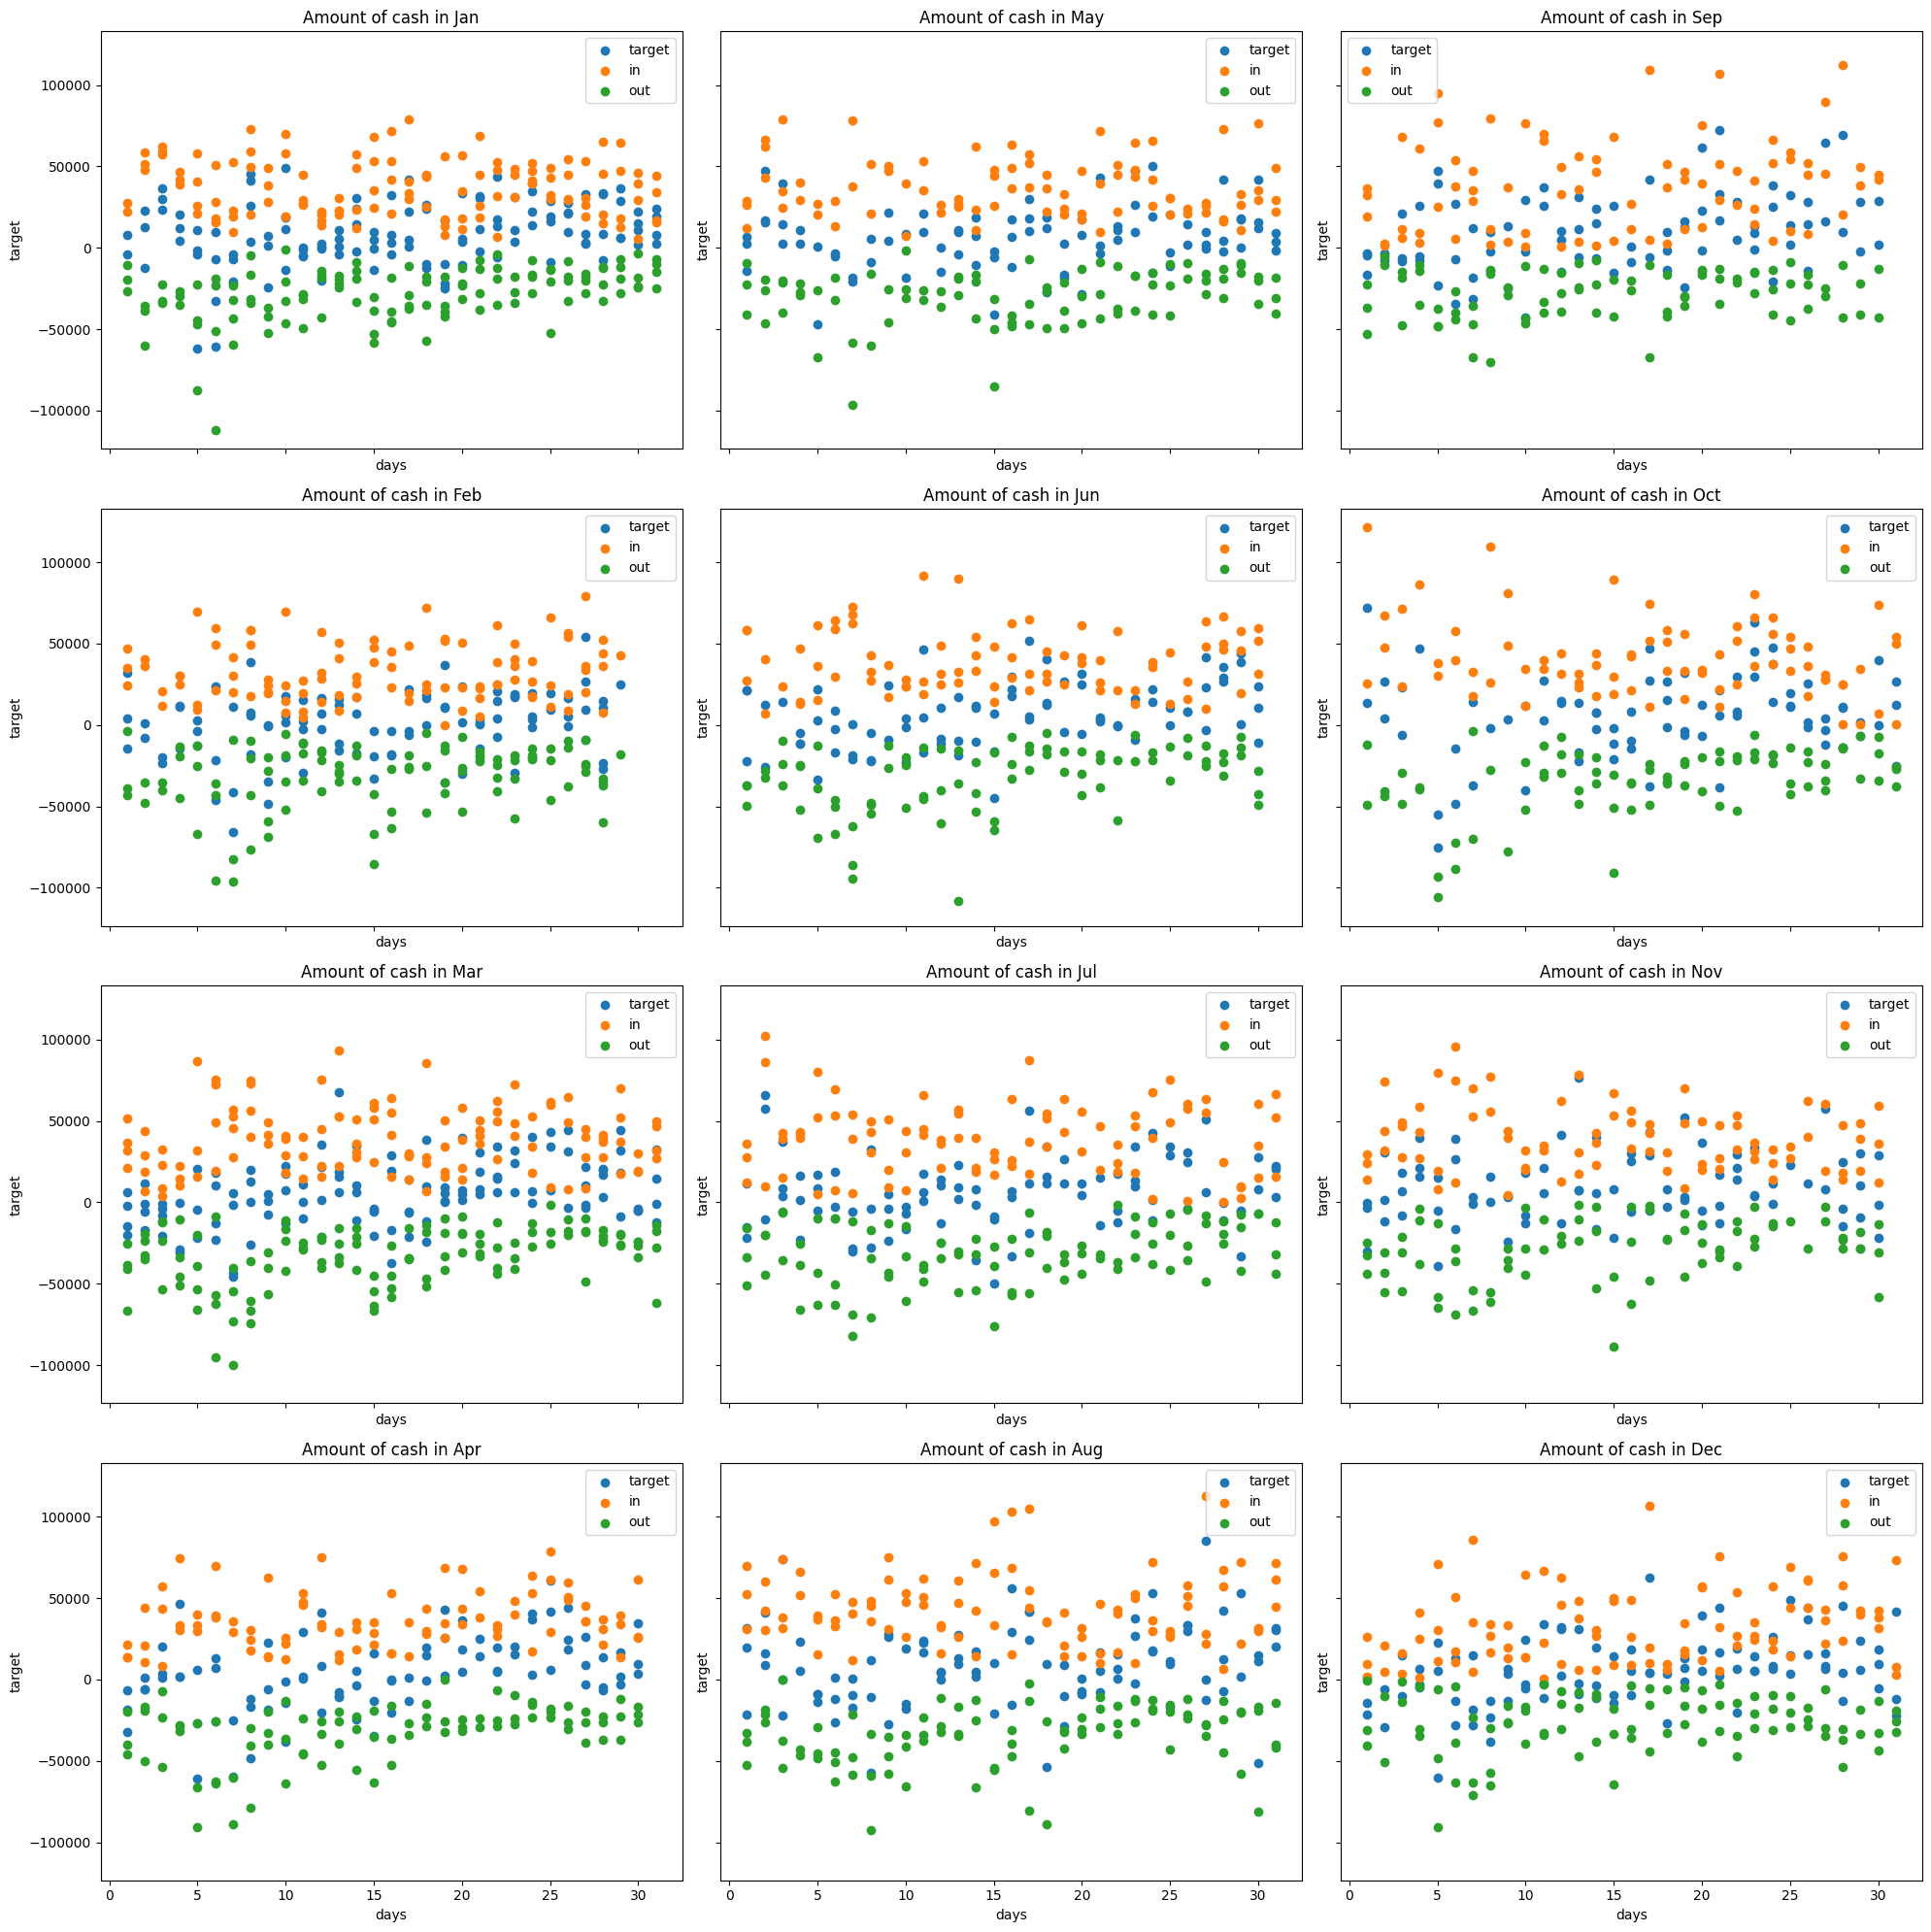

In [14]:
fig, plots = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(20,20))
for month in range(12):
  month_data = df[df['Month'] == month+1]
  days = month_data['Day']
  plots[month%4, month//4].scatter(days, month_data.target, label='target')
  plots[month%4, month//4].scatter(days, month_data.CashIn, label='in')
  plots[month%4, month//4].scatter(days, month_data.CashOut, label='out')
  plots[month%4, month//4].legend()
  plots[month%4, month//4].set_ylabel('target')
  plots[month%4, month//4].set_xlabel('days')
  plots[month%4, month//4].set_title(f'Amount of cash in {calendar.month_abbr[month+1]}')
fig.tight_layout()
fig.show()

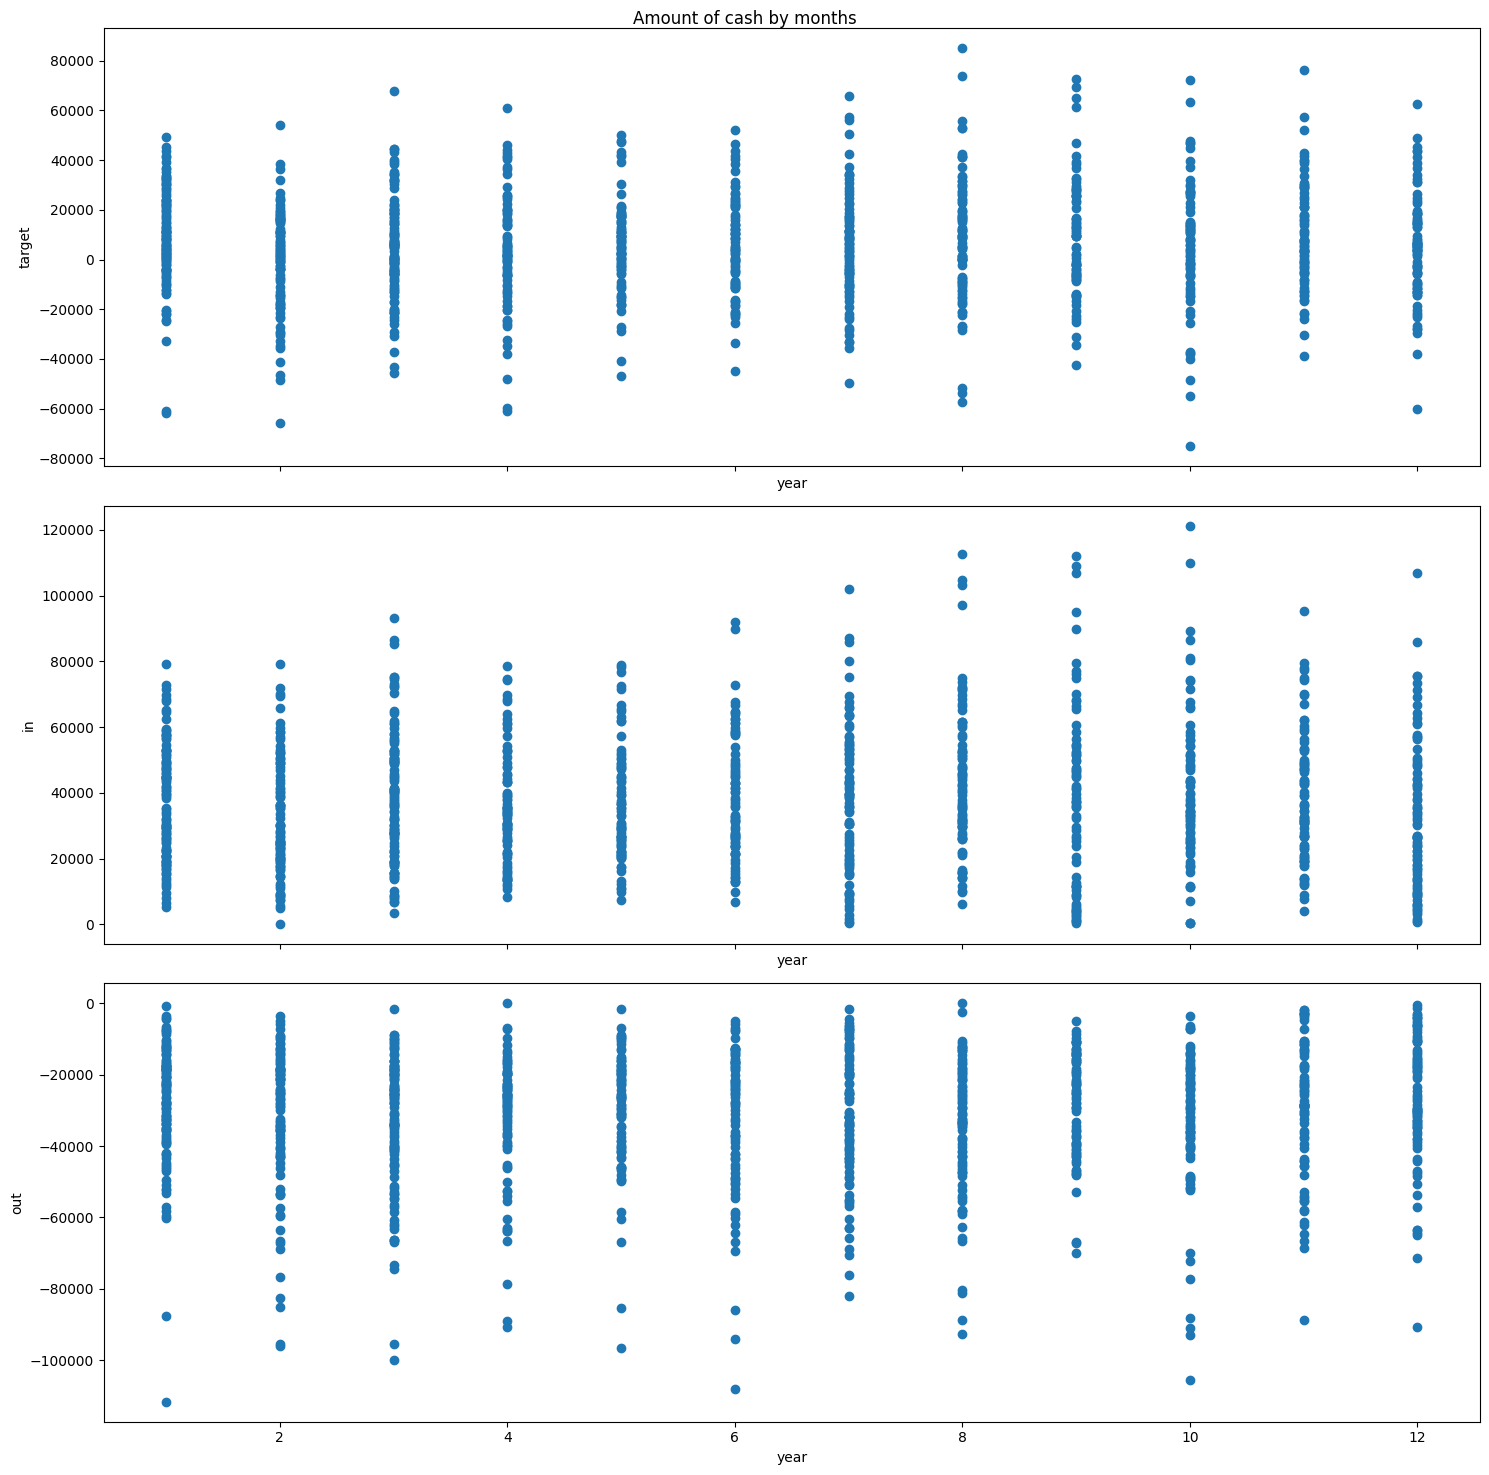

In [15]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.scatter(df['Month'], df['target'])
ax1.set_ylabel('target')
ax1.set_xlabel('year')

ax2.scatter(df['Month'], df['CashIn'])
ax2.set_ylabel('in')
ax2.set_xlabel('year')

ax3.scatter(df['Month'], df['CashOut'])
ax3.set_ylabel('out')
ax3.set_xlabel('year')

fig.suptitle('Amount of cash by months')
fig.tight_layout()
fig.show()

Анализ распеределения по месяцам уже более информативный. Например, точно можно сказать, что в январе в банкоматах оказывается больше наличных, чем в феврале. Такая сезонность кажется оправданной (к примеру, можно ожидать, что в те месяцы, когда больше праздников, больше снимают денег, как в декабре в странах, где отмечается рождество 25 декабри или Новый год).

In [16]:
df['Weekday'] = df['Date'].apply(toweekday)

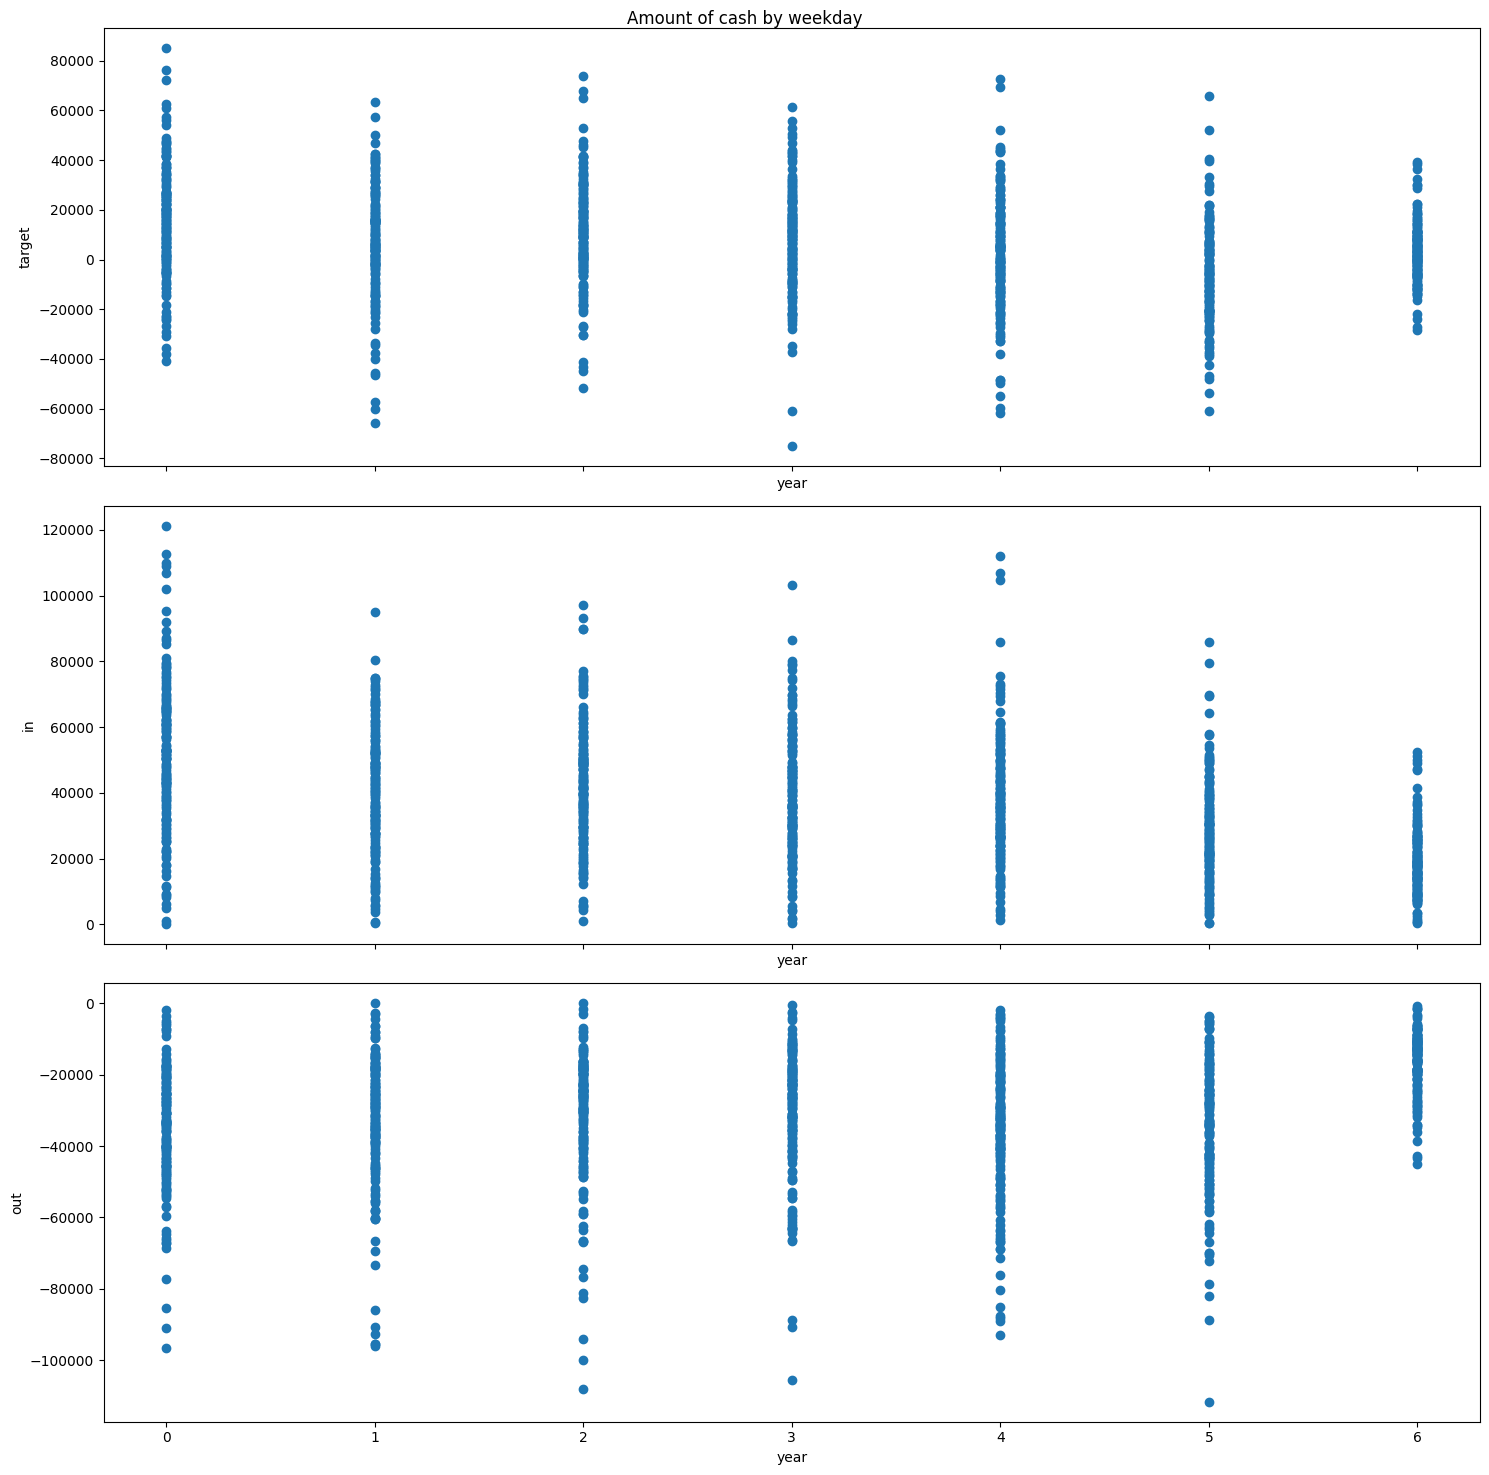

In [17]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
ax1.scatter(df['Weekday'], df['target'])
ax1.set_ylabel('target')
ax1.set_xlabel('year')

ax2.scatter(df['Weekday'], df['CashIn'])
ax2.set_ylabel('in')
ax2.set_xlabel('year')

ax3.scatter(df['Weekday'], df['CashOut'])
ax3.set_ylabel('out')
ax3.set_xlabel('year')

fig.suptitle('Amount of cash by weekday')
fig.tight_layout()
fig.show()

Недельная сезонность также можно проследить по распределению выше. Видно, что больше всего денег снимают в субботу, а вносят -- в понедельник, что очевидно, ведь в выходные люди тратят больше.

In [18]:
df['DDate'].corr(df['target'], method='spearman'), df['Year'].corr(df['target'], method='spearman'), \
df['Month'].corr(df['target'], method='spearman'), df['Weekday'].corr(df['target'], method='spearman')

(0.06782650421267335,
 0.05654393571735634,
 0.019544959463316098,
 -0.25222070061343344)

In [19]:
df['DDate'].corr(df['CashIn'], method='spearman'), df['Year'].corr(df['CashIn'], method='spearman'), \
df['Month'].corr(df['CashIn'], method='spearman'), df['Weekday'].corr(df['CashIn'], method='spearman')

(0.29589562369333744,
 0.2984880847840716,
 0.011191382329160803,
 -0.4436582844403103)

In [20]:
df['DDate'].corr(df['CashOut'], method='spearman'), df['Year'].corr(df['CashOut'], method='spearman'), \
df['Month'].corr(df['CashOut'], method='spearman'), df['Weekday'].corr(df['CashOut'], method='spearman')

(-0.2776163477469044,
 -0.293706835600925,
 0.011409143261583498,
 0.23597685568161644)

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [21]:
from etna.datasets import TSDataset
import math

In [22]:
data = deepcopy(df)
data = pd.melt(data)

In [23]:
timestamps = data[data['variable'] == 'Date'].drop('variable', axis=1).rename(columns={'value': 'timestamp'})

In [24]:
target = deepcopy(timestamps)
target['segment'] = 'target'
target['target'] = data['value'][data['variable'] == 'target'].apply(lambda x: np.int32(x) if not math.isnan(x) else x).values
in_ = deepcopy(timestamps)
in_['segment'] = 'in'
in_['target'] = data['value'][data['variable'] == 'CashIn'].apply(lambda x: np.int32(x) if not math.isnan(x) else x).values
out_ = timestamps
out_['segment'] = 'out'
out_['target'] = data['value'][data['variable'] == 'CashOut'].apply(lambda x: np.int32(x) if not math.isnan(x) else x).values

In [25]:
to_ts = pd.concat((target, in_, out_), axis=0)

In [26]:
ts_format = TSDataset.to_dataset(to_ts)
ts = TSDataset(ts_format, freq='D')

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [27]:
from etna.transforms import TimeSeriesImputerTransform

In [28]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
in,2016-01-05,2019-03-31,1182,101,3,0,0,0,D
out,2016-01-05,2019-03-31,1182,88,3,0,0,0,D
target,2016-01-05,2019-03-31,1182,110,3,0,0,0,D


Пропущенных значения доволььно много. На мой взгляд, наиболее оправдано использование метода _running mean_, потому что таким образом мы не так сильно повлияем на нахождение тренда и не "подтасуем" данные при определении сезонности (что могло бы произойти при выборе метода _seasonal_) и, кажется, не так сильно смажем их, как могло бы быть при выборе метода _forward fill_.

In [29]:
fillna = TimeSeriesImputerTransform(strategy="running_mean", window=50)

In [30]:
ts_new = deepcopy(ts)
ts_new.fit_transform([fillna])

In [31]:
ts_new.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
in,2016-01-05,2019-03-31,1182,0,3,0,0,0,D
out,2016-01-05,2019-03-31,1182,0,3,0,0,0,D
target,2016-01-05,2019-03-31,1182,0,3,0,0,0,D


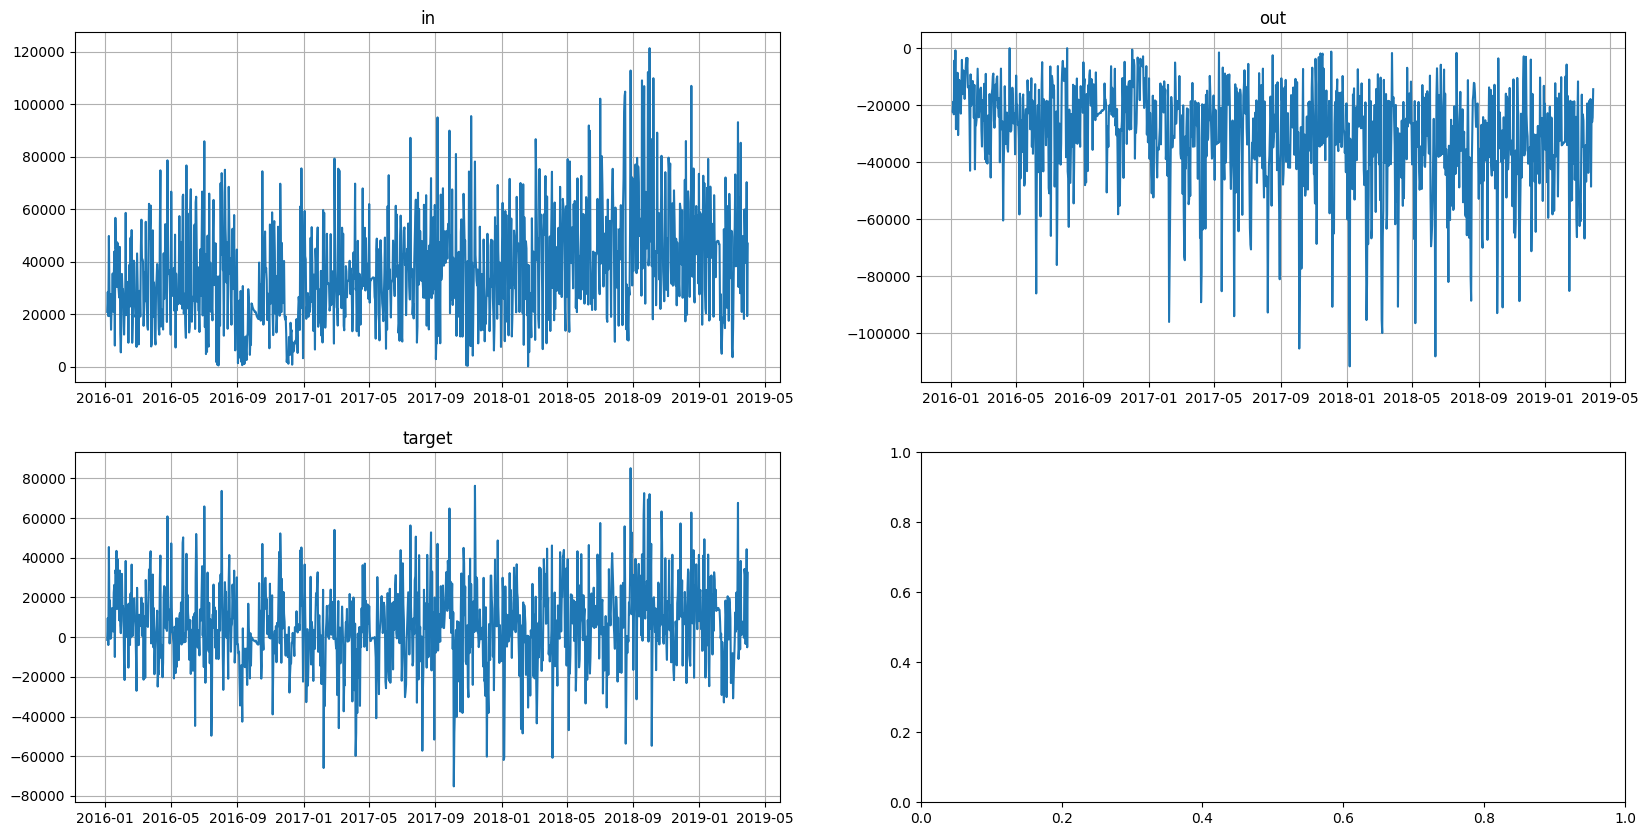

In [32]:
ts_new.plot()

В том месте, где было пропущенно много данных (~октябрь 2016), замена бросается в глаза (там образовалось неестественное плато), но я надеюсь, что сгенерированные данные перекроются настоящими

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

In [33]:
from etna.analysis.outliers import get_anomalies_median
from etna.analysis import plot_anomalies, plot_anomalies_interactive
from etna.transforms import MedianOutliersTransform

In [34]:
plot_anomalies_interactive(ts_new, segment='target' ,method=get_anomalies_median, params_bounds={'window_size': (10, 200, 10), 'alpha': (0.5, 7, 0.5)})

interactive(children=(IntSlider(value=10, continuous_update=False, description='window_size', max=200, min=10,…

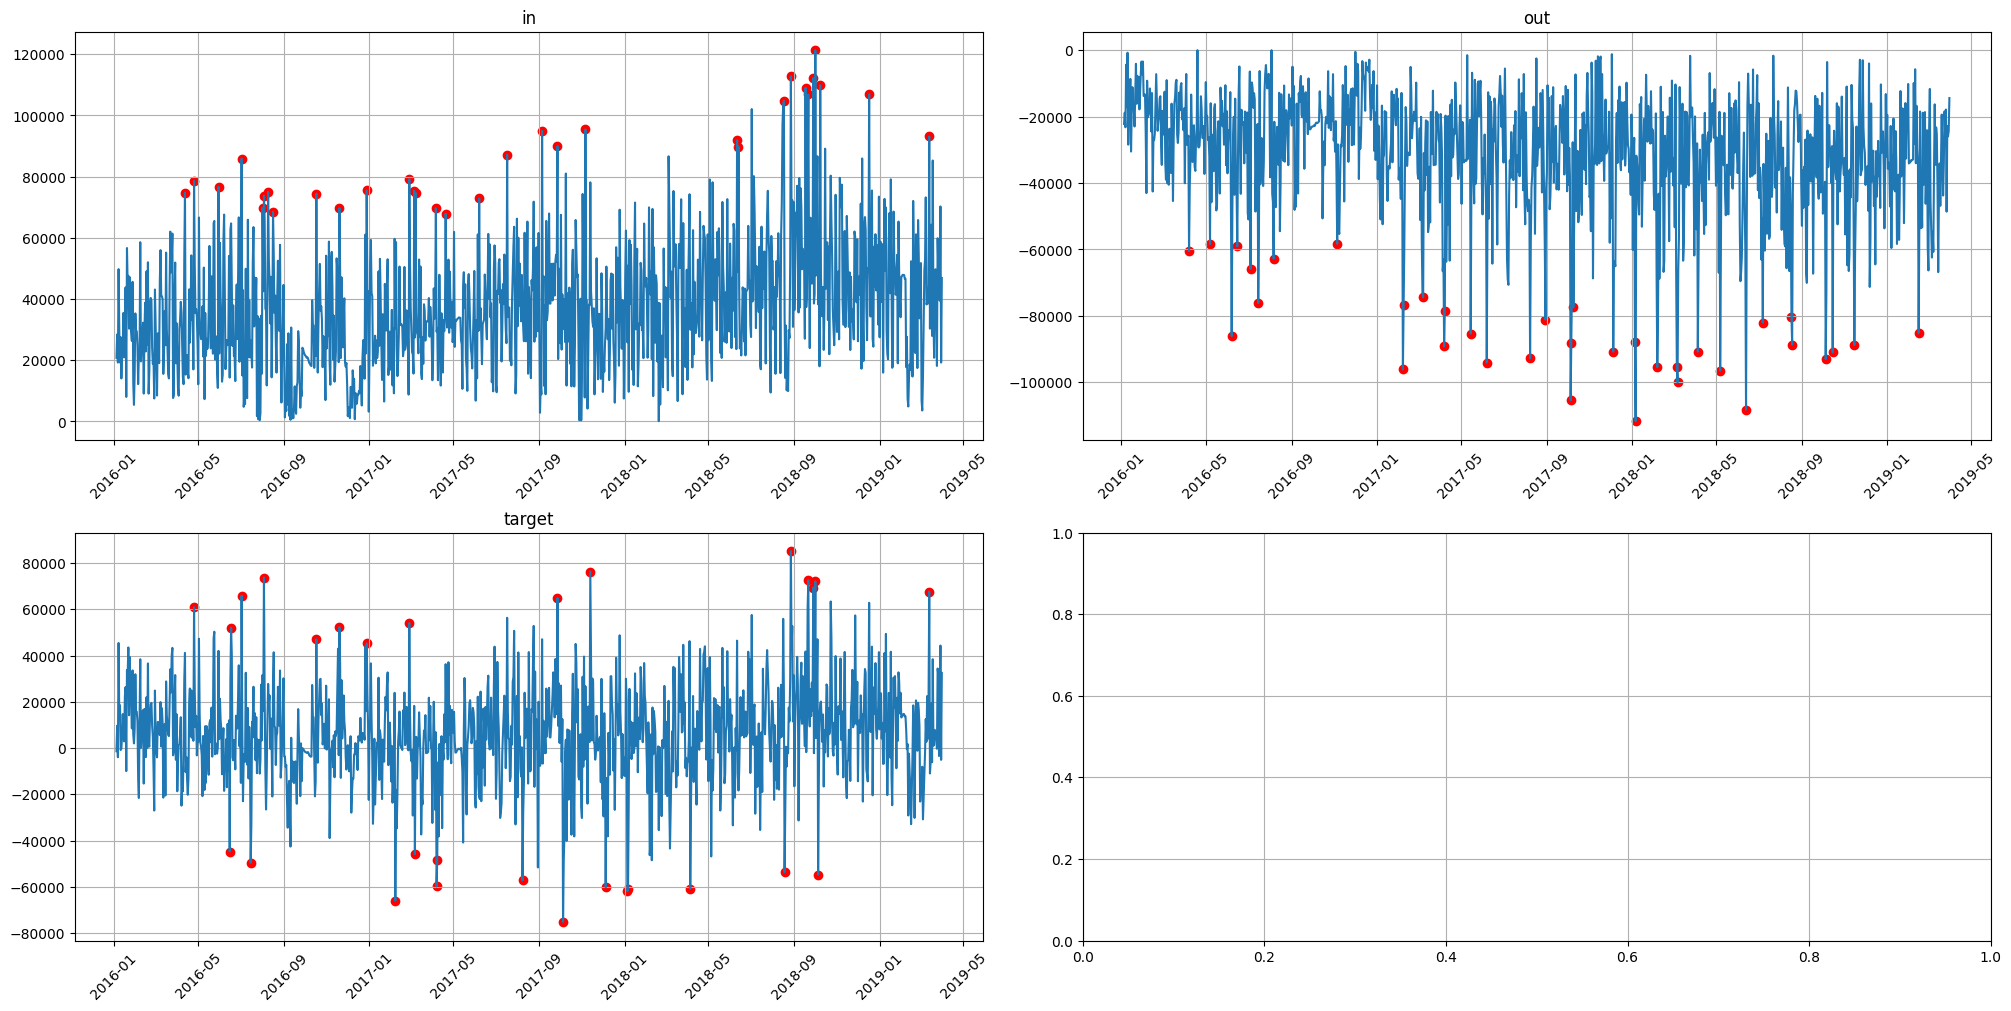

In [35]:
anomaly_dict = get_anomalies_median(ts_new, window_size=180, alpha=2.5)
plot_anomalies(ts_new, anomaly_dict)

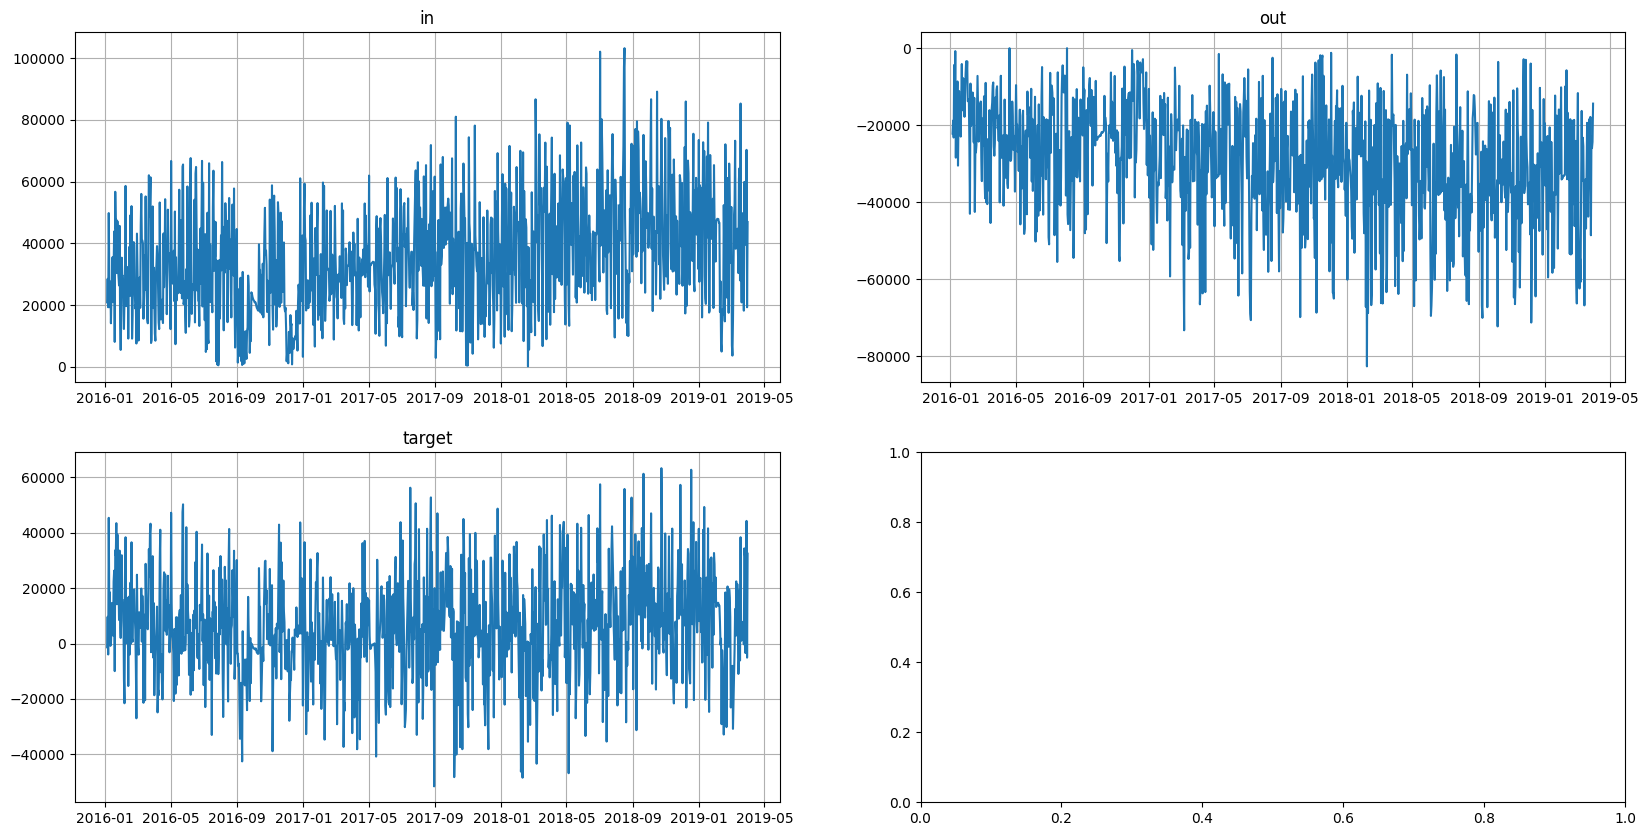

In [36]:
outliers_remover = MedianOutliersTransform(in_column="target", window_size=180, alpha=2.5)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=50)
ts_new.fit_transform([outliers_remover, outliers_imputer])
ts_new.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [37]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest, plot_forecast

In [38]:
HORIZON = 5
model = ProphetModel()

In [ ]:
pipeline = Pipeline(model=model, horizon=HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_new, n_folds=4, metrics=[MAE(), SMAPE()])

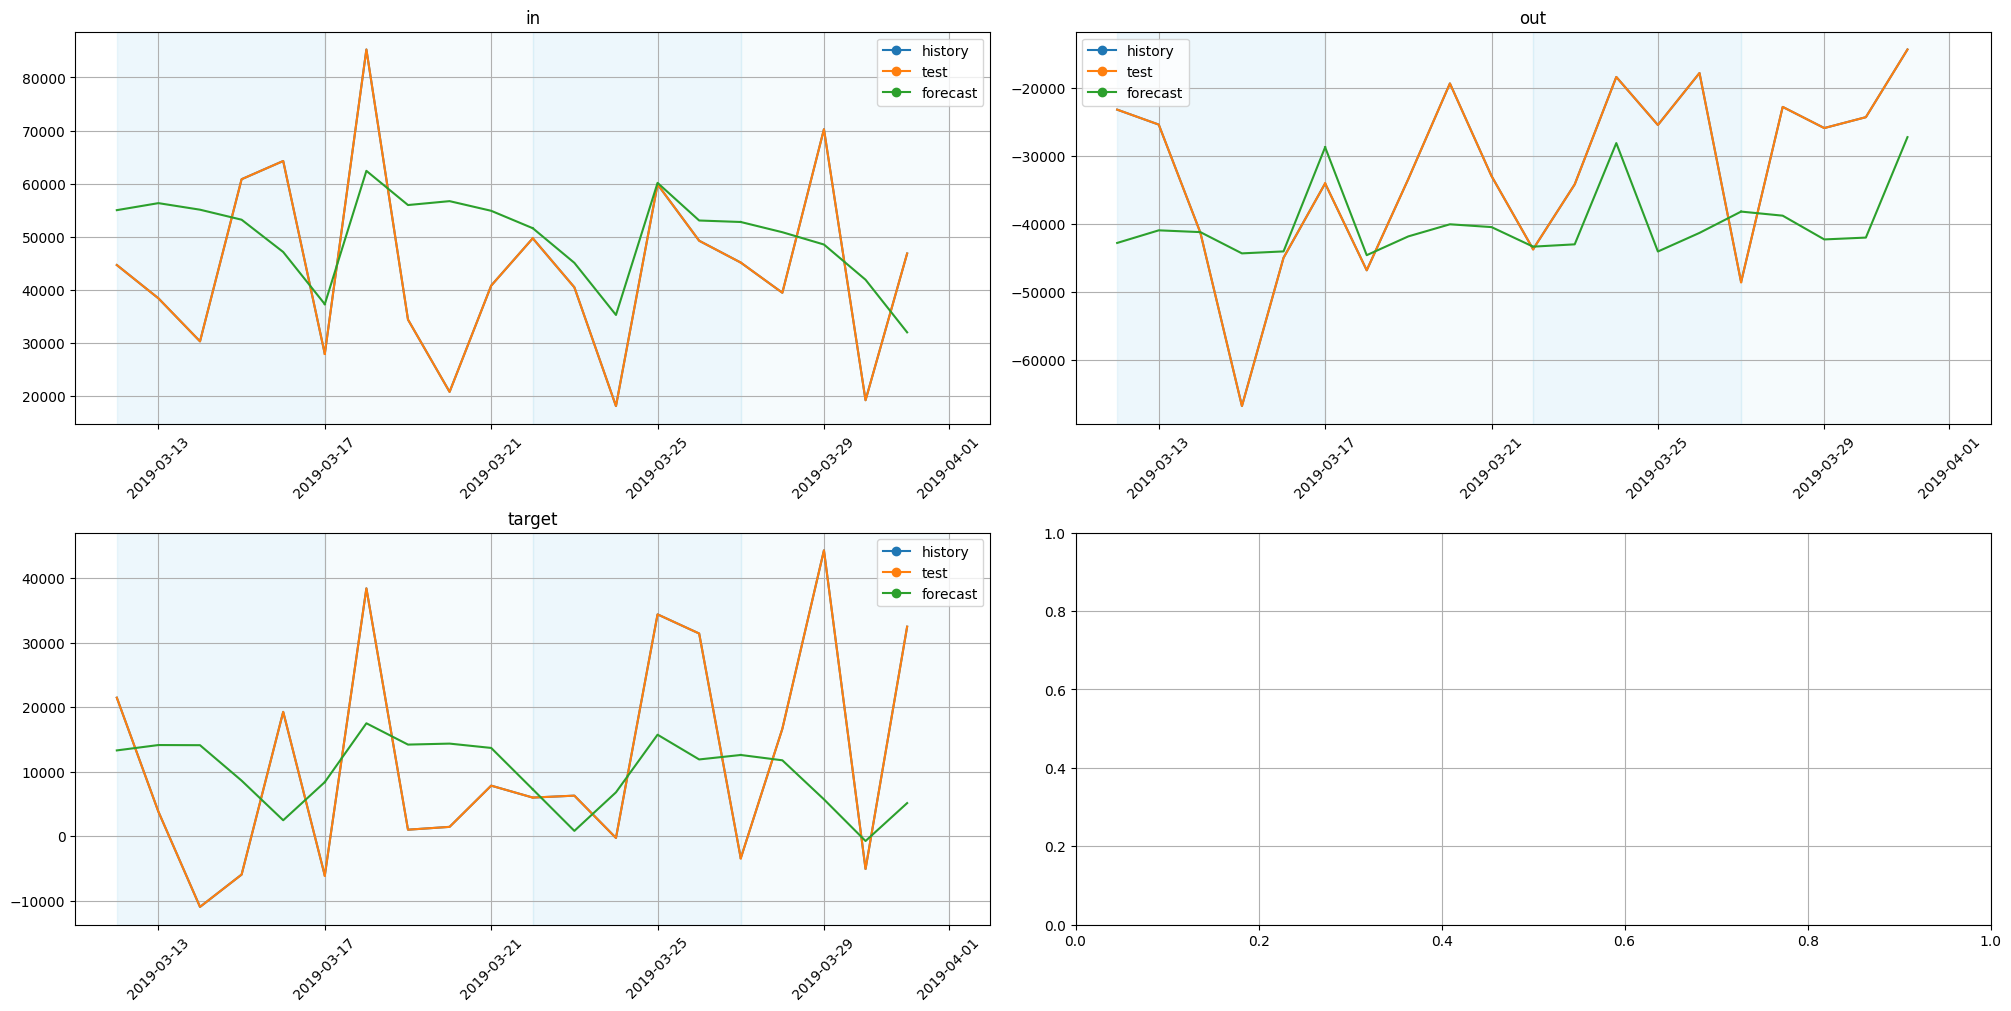

In [40]:
plot_backtest(forecast_df, ts_new)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [41]:
metrics_df

,segment,MAE,SMAPE,fold_number
2,in,15555.371419,32.126438,0
2,in,20750.925885,45.865349,1
2,in,5548.838242,17.317842,2
2,in,15652.086083,37.824139,3
0,out,11718.692470,29.752148,0
0,out,8839.799944,26.850018,1
0,out,12201.880346,39.640281,2
0,out,14663.732708,47.768046,3
1,target,14991.870755,143.466998,0
1,target,13472.603032,133.382732,1


### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [42]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [43]:
hierarchical_structure = HierarchicalStructure(level_structure={"total": ["in", "out"]}, level_names=["total", "input"])
hierarchical_ts = TSDataset(df=ts_format[['in', 'out']], freq="D", hierarchical_structure=hierarchical_structure)
reconciliator = BottomUpReconciliator(target_level="total", source_level="input")

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MASE и MAE на кросс-валидации.

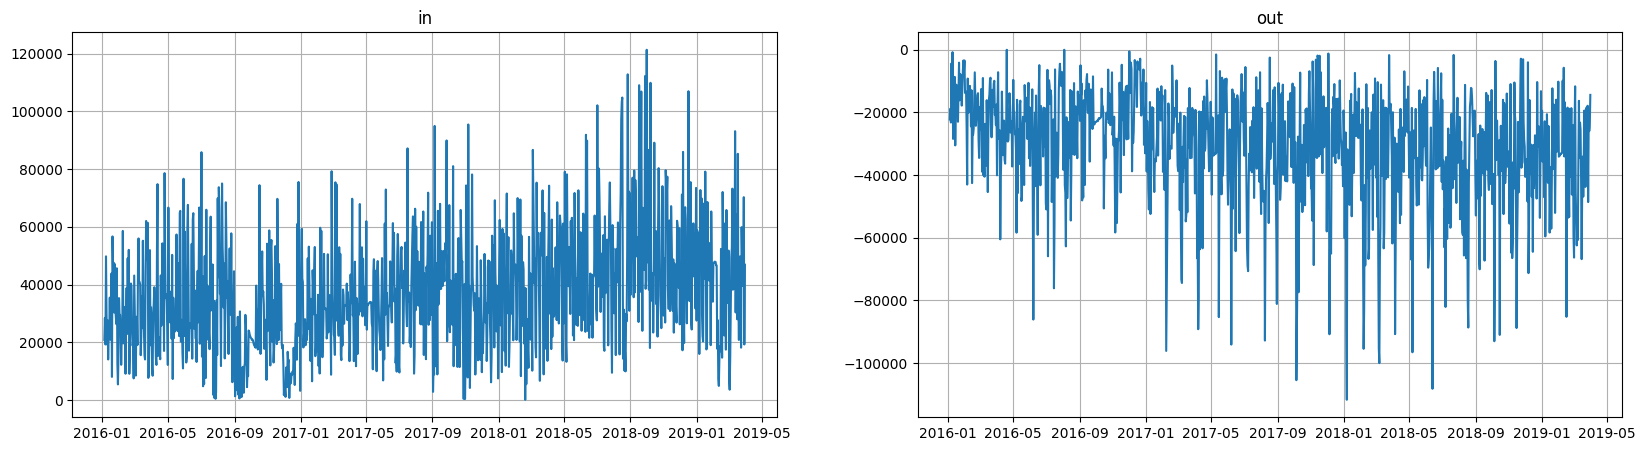

In [44]:
outliers_remover = MedianOutliersTransform(in_column="target", window_size=180, alpha=2.5)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=50)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
hierarchical_ts.plot()

In [45]:
hierarchical_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
in,2016-01-05,2019-03-31,1182,0,2,0,0,0,D
out,2016-01-05,2019-03-31,1182,0,2,0,0,0,D


In [46]:
reconciliator.fit(ts=hierarchical_ts)
pipeline = HierarchicalPipeline(model=model, reconciliator=reconciliator)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=hierarchical_ts, n_folds=4,  metrics=[MAE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h9juyo4/fgzthqok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h9juyo4/_iswwb0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42842', 'data', 'file=/tmp/tmp4h9juyo4/fgzthqok.json', 'init=/tmp/tmp4h9juyo4/_iswwb0j.json', 'output', 'file=/tmp/tmpjri_7d6r/prophet_model-20230507091922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

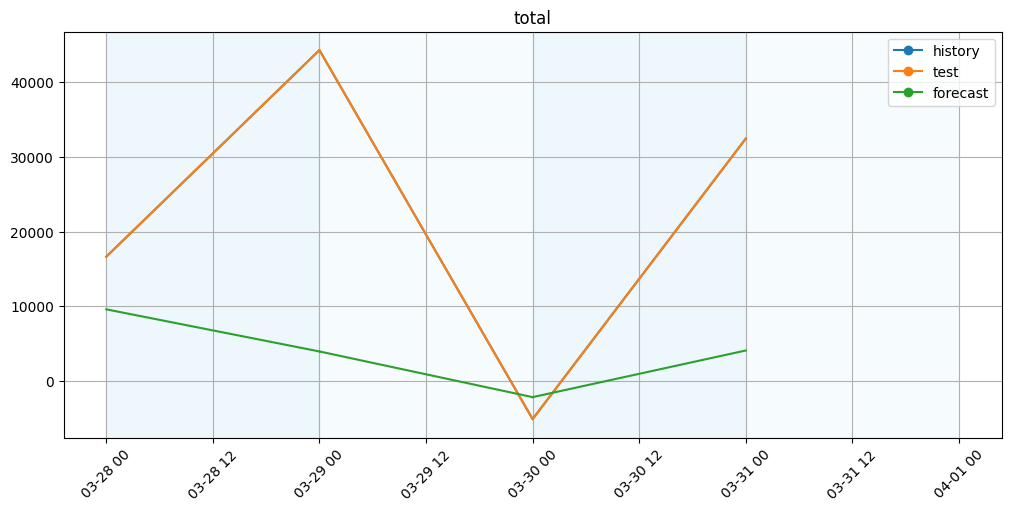

In [47]:
plot_backtest(forecast_df, reconciliator.reconcile(hierarchical_ts))

In [48]:
metrics_df

,segment,MAE,SMAPE,fold_number
0,total,7042.170349,53.679519,0
0,total,40353.296708,167.209666,1
0,total,2939.293234,80.964383,2
0,total,28382.335139,155.274333,3


### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [49]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

In [ ]:
#YOUR CODE HERE#

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#